<a href="https://colab.research.google.com/github/olgaminguett/ET5003_SEM1_2021-2/blob/main/ET5003_Etivity1_OlgaMinguett_20179766.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-1

In [1]:
#@title Current Date
Today = '2021-08-22' #@param {type:"date"}


In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20179760" #@param {type:"string"}
Student_full_name = "Olga Minguett" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

## MNIST dataset



The MNIST database  is a dataset of handwritten digits that has been and is extensively used in machine learning. There are $10$ classes, each image is $28\times28$ pixels and, therefore, each input is $x_i\in\mathbb{R}^{784}$. 

## Task

You have to extend the code to manage any arbitrary number of classes, in other words you have to implement a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier.

You must then select  3 digits at random and perform  the following task. 

1. Your goal is to use Bayesian multinomial logistic regression (as in the road-sign notebook) to solve this classification problem. 

2. You can downsize the training dataset (e.g., 40% training and 60%testing) if the computation of the posterior takes too much time in your computer.

3. Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

4. Then you need to compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

5. In practice, the task is to use uncertainty estimation to detect the difficult instances in the test-set. This is equivalent to refuse to classify all high-uncertainty instances or, in other words, when we are uncertain we say "I don't know" and we do not return any class. In this way, you will learn how uncertainty can be used to make safer decisions, by detecting the instances that are difficult to classify.


## Libraries

In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Import libraries
import random

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from collections import Counter
import sklearn.preprocessing
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from scipy.special import erf
import scipy.optimize as optimize
import pickle
import theano as tt
from tqdm import tqdm
from IPython.display import HTML
import cv2 #Pre-built CPU-only OpenCV packages for Python.
import arviz as az # Python package for exploratory analysis of Bayesian models
import pymc3 as pm # Python package for Bayesian statistical modeling and probabilistic ML
from skimage.io import imread, imshow # Utilities to read and write images in various formats
from skimage.color import rgb2gray #Python package designed for image preprocessing

%matplotlib inline

In [6]:
# Setting a seed:
np.random.seed(123)

## Dataset

### Loading the MNIST dataset

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Path, copy the path from your Drive
# Downloaded from: https://www.kaggle.com/oddrationale/mnist-in-csv?select=mnist_test.csv
Path = '/content/drive/My Drive/Colab Notebooks/mnist/' 

# MNIST Data
train_data = Path + 'mnist_train.csv'
test_data = Path + 'mnist_test.csv'

# train data
df_train = pd.read_csv(train_data)
X_train = df_train.drop("label",axis=1).values
y_train = df_train.label.values
print('Train data Shape',X_train.shape)

# test data
df_test = pd.read_csv(test_data)
X_test = df_test.drop("label",axis=1).values
y_test = df_test.label.values
print('Test data Shape',X_test.shape)

Train data Shape (60000, 784)
Test data Shape (10000, 784)


**Note:** The MNIST dataset [1] contains 60.000 digit for the training sample and 10.000 digit for the test samples, both by 784 bytes. The digits have been size-normalized and centered in a fixed-size image. The images are 28x28 pixel, represented as below: 

In [9]:
print (X_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 241   0   0   0   0   

In [10]:
# Normalizing the Inputs:
X_train = X_train/255
X_test = X_test/255

# Printing the new input range of values:
minv = np.min(X_train)
maxv = np.max(X_train)
print(minv,maxv)

0.0 1.0


**Note:** after normalizing the image pixel values to a range from 0 to 1 by dividing between 255, computation becomes easier and faster as the numbers are small.

### Description of Data:

In [11]:
# Number of examples
n_train =  len(X_train)
n_test =  len(X_test)

# Shape of an traffic sign image
image_shape = X_train.shape[1]

# unique classes/labels in the training dataset.
alltotal = set(y_train)
n_classes = len(alltotal)

print("Number of Training examples =", n_train)
print("Number of Test examples =", n_test)
print("Image input shape =", image_shape)
print("Number of classes =", n_classes)

Number of Training examples = 60000
Number of Test examples = 10000
Image input shape = 784
Number of classes = 10


### Class Distribution:

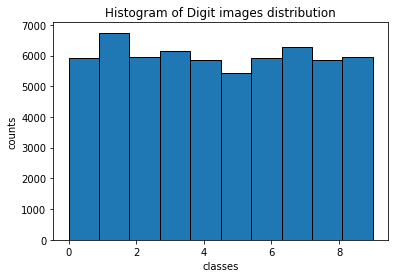

In [12]:
fig, ax = plt.subplots()
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, ec='black', align='mid')
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of Digit images distribution')
plt.show()

## Downsampling

### Randomly selecting 3 of the 10 Digit Classes

In [13]:
# We select the number of Classes we want:
n_classes = 3

# Empty list to append the random digit classes we select:
classes = []

# We select 3 digits at random and make sure they are unique:
while len(classes) < n_classes:
    
    # Randomly drawing a digit from 0-9:
    num2choose = np.random.randint(0,10)

    # Append the digit if it's not already in our list of classes:
    if num2choose not in classes: 
        classes.append(num2choose)
        
        
# Sorting the Classes smallest to largest    
classes.sort()
# print classes selected
classes

[1, 2, 6]

**Note**: In this case classes chosen were 1,2&6. Follow by, the selected number of instances is 5000 per digit.

In [14]:
# The number of instances we'll keep for each of our 3 digits:
inst_class = 3000
inputs = []
labels = []

# Loop to randomly sample the instances for each digit:
for r in classes:
    imgs = X_train[np.where(y_train==r)[0],:]
    inputs.append(imgs[np.random.permutation(imgs.shape[0]),:][0:inst_class,:])
    labels.append(np.ones(inst_class)*r)
    
# Shaping inputs and labels in the right format    
X_train = np.vstack(inputs).astype(np.float64)
y_train = np.hstack(labels)

In [15]:
print('Train Data:')
print (X_train,y_train)
print('Train Data Shapes:')
print (X_train.shape,y_train.shape)

Train Data:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [1. 1. 1. ... 6. 6. 6.]
Train Data Shapes:
(9000, 784) (9000,)


**Note**: As above mentioned 3000 instances per digit, which represents 9000 instances by 784 pixels.

New Classes Distribution

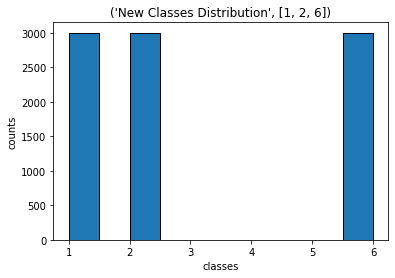

In [16]:
# new histogram
fig, ax = plt.subplots()
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, ec='black', align='mid')
ax.set_xlabel('classes')
ax.set_ylabel('counts')
title = 'New Classes Distribution', classes
plt.title(title)
plt.show()

In [17]:
# plot digits
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg', **options)
    plt.axis("off")

Text(0.5, 1.0, 'Show images from each Digit')

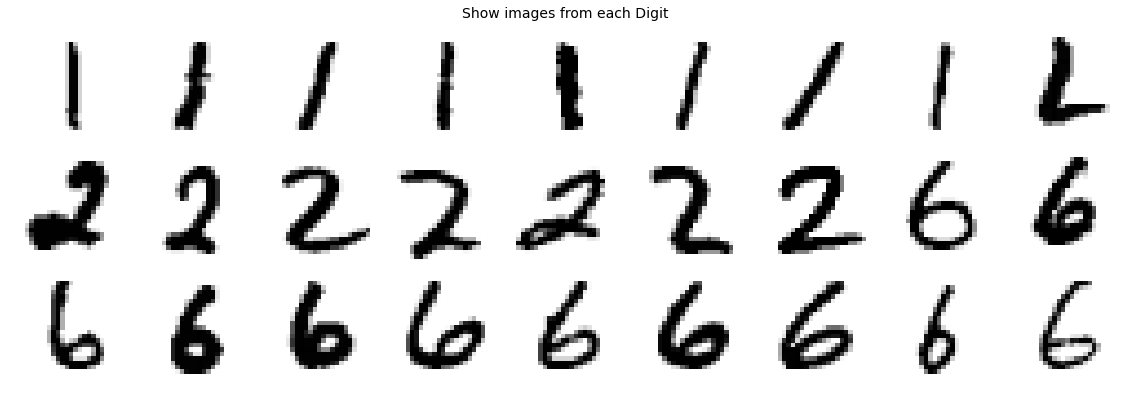

In [18]:
# Show a few instances from each Digit:
plt.figure(figsize=(20,20))
images_per_classes = 9
label_indices = []
# Selecting a few label indices from each of the 3 classes to show:
for i in range(n_classes):
  for i in range(images_per_classes):
    # take index randomly chosen
    label_indices.append(random.randint(0, len(X_train)))
    # choose the image according to the index
    image = X_train[label_indices[i] - 1]

# Sorting the Classes smallest to largest
label_indices.sort()

# Plotting 'original' image
plot_digits(X_train[label_indices,:],images_per_row=9)
plt.title("Show images from each Digit", fontsize=14)

**Note**: Some of the digits look messy, even though the images are distinguisable, as 1,2&6s.

###  Splitting the Training data into both Training and Validation Sets:

- Although this is the Training set, we can still set aside some samples (for instance 20%) of the 1,500 instances we have for Model Validation purposes.


- With that Validation Set, we can then select the amount of Uncertainty we are happy with from our Model to use out of sample on other unseen data.


- We can then test out how well our decision performs on the Test Set that we put aside earlier.

In [19]:
### Split tha dataset in training and validation sets
# choose the fraction of your validation data from the training set
w = 0.20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=w, random_state=0)
 
# Shuffling the training instaces around to randomize the order of inputs to the model:
X_train, y_train = shuffle(X_train, y_train)

In [20]:
# print shape of your validation and training set
print('Training Set Shape:')
print('X:', X_train.shape)
print('y:', y_train.shape)
print('Validation Set Shape:')
print('X: ', X_val.shape)
print('y: ', y_val.shape)

Training Set Shape:
X: (7200, 784)
y: (7200,)
Validation Set Shape:
X:  (1800, 784)
y:  (1800,)


### Encoding the Class labels for the Probabilistic ML Model:

This is an example:

- **[1,0,0]** for first digit
- **[0,1,0]** for second digit
- **[0,0,1]** for third digit

### General-Recipe ML - Logistic Regression Model

In [21]:
# model
model_log = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial')
model_log.fit(X_train, y_train)

# Classification:
y_pred_log = model_log.predict(X_val)
y_pred_logi_prob = model_log.predict_proba(X_val)

# Maybe taking the maximum probability 
# in any of the classes for each observation
prob_classmax = np.max(y_pred_logi_prob,axis=1)

# Computing the Accuracy:
print('Accuracy Score: ', accuracy_score(y_pred_log, y_val))

Accuracy Score:  0.9711111111111111


In [22]:
# General-recipe probabilistic calculation of wrong instances
prob_classmax[y_pred_log!=y_val]
prob_classmax[y_pred_log!=y_val].shape

(52,)

**Note**: For the digit classess 1,2 & 6, accuracy score is 0.974 which is a very good outcome to detect digits, where 78 instaces were incorrected classified within the classes selected.

Confusion Matrix 

Text(0.5, 69.0, 'Predicted Label')

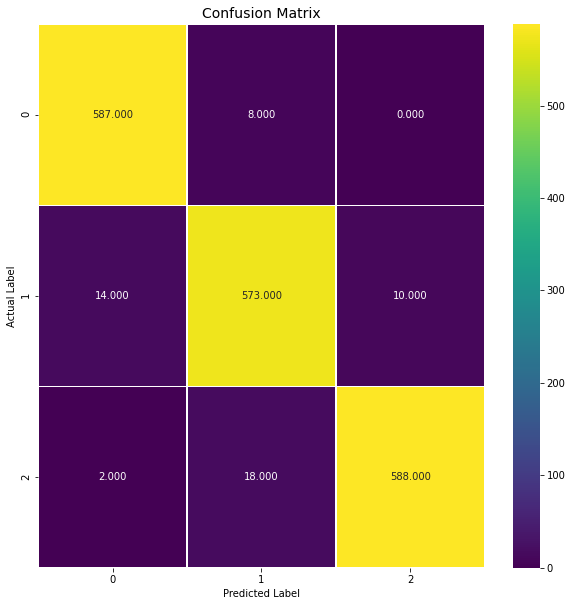

In [23]:
# Confusion Matrix 
plt.figure(figsize=(10,10))
plt.title('Confusion Matrix', fontsize=14)
cm = metrics.confusion_matrix(y_val, y_pred_log)
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.6, cmap = 'viridis')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

### Probabilistic Multinomial Logistic Regression:

The Multinomial Logistic Regression has some parameters:

- $\alpha$, which is the intercept term:

- $\beta$, which is a vector of coefficients which give a weighting to the importance of each input feature:


In [24]:
## We use LabelBinarizer to transfor classes into counts
# neg_label=0, pos_label=1 
y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_train.reshape(-1,1))
nf = X_train.shape[1]

# number of classes
nc = len(classes)
# floatX = float32
floatX = tt.config.floatX

init_b = np.random.randn(nf, nc-1).astype(floatX)
init_a = np.random.randn(nc-1).astype(floatX)


with pm.Model() as multi_logistic:
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(nf, nc-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(nc-1,), testval=init_a)
    
    # we need to consider nc-1 features because the model is not identifiable
    # the softmax turns a vector into a probability that sums up to one
    # therefore we add zeros to go back to dimension nc
    # so that softmax returns a vector of dimension nc
    β1  = tt.tensor.concatenate([np.zeros((nf,1)),β ],axis=1)
    α1  = tt.tensor.concatenate([[0],α ],)
    
    # Likelihood
    mu = pm.math.matrix_dot(X_train,β1) + α1
    # It doesn't work if the problem is binary
    p = tt.tensor.nnet.nnet.softmax(mu)
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)

In [25]:
# Model training
with multi_logistic:
    approx = pm.fit(3000, method='advi')

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 14,466


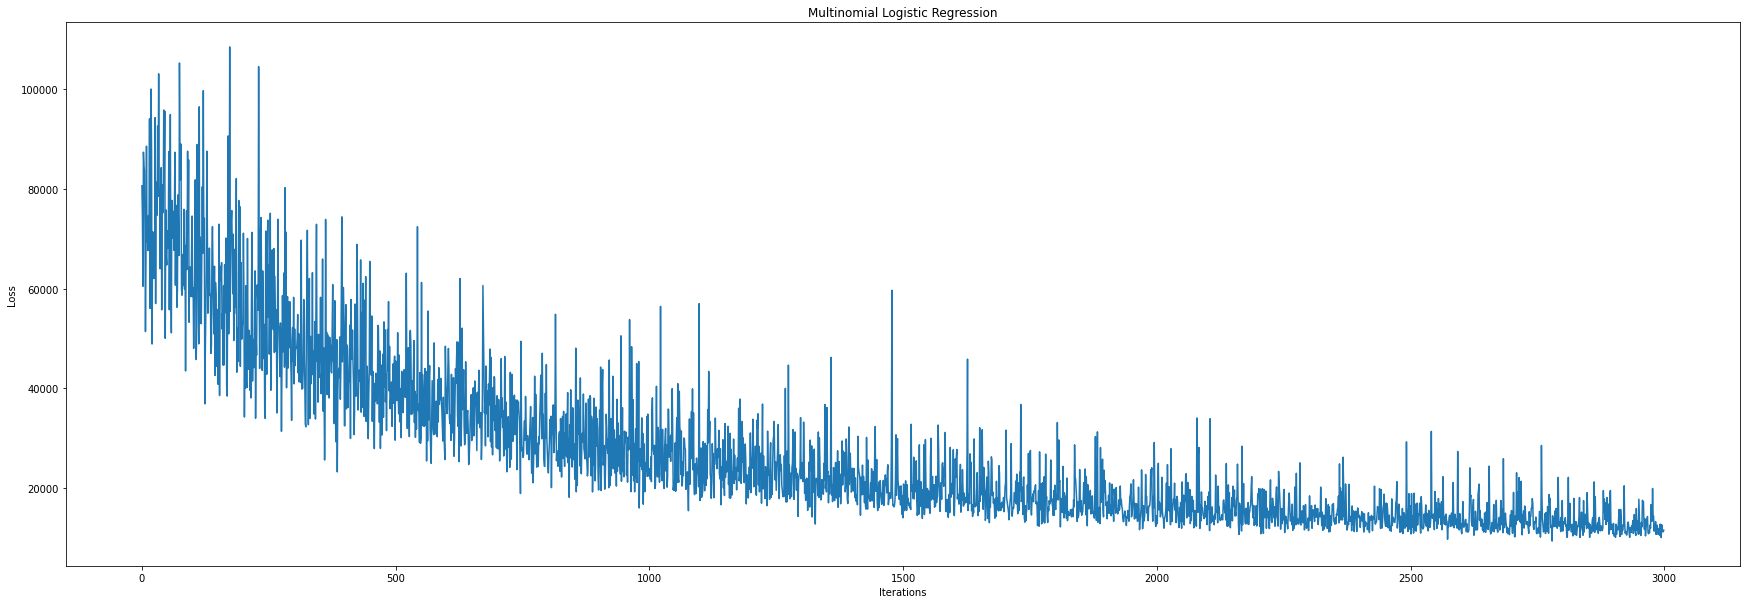

In [26]:
plt.figure(figsize=(30,10))
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title('Multinomial Logistic Regression')
plt.plot(approx.hist)
plt.show();

**Note**: The Histogram above displays the loss per iteration of the Multi Logistic Regression Model using PyMC3 automatic differentiation variational inference(ADVI) method. In this case, the average loss per iteration is 17.824 at 3000 iteration.

In [27]:
dd = 300
posterior = approx.sample(draws=dd)

test image #186
posterior sample #135
true class= 1.0
classes: [1, 2, 6]
estimated prob= [0.99856592 0.00001362 0.00142045]


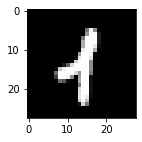

In [28]:
## The softmax function transforms each element of a collection by computing the exponential
#  of each element divided by the sum of the exponentials of all the elements.
from scipy.special import softmax

#select an image in the test set
#i = 10 
i = random.randint(0, dd)

#select a sample in the posterior
#s = 100 
s = random.randint(0, dd)

beta  = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
image = X_val[i,:].reshape(28,28)
plt.figure(figsize=(2,2))
plt.imshow(image,cmap="Greys_r")
np.set_printoptions(suppress=True)

print("test image #" + str(i))
print("posterior sample #" + str(s))
print("true class=", y_val[i])
print("classes: " + str(classes))
print("estimated prob=",softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

**Note**: This test image show us a very clear 2

In [29]:
# Bayesian prediction
# return the class that has the highest posterior probability
y_pred_Bayesian=[]

for i in range(X_val.shape[0]):
    val=np.zeros((1,len(classes)))
    
    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])     
        val = val + softmax((np.array([X_val[i,:].dot(beta) + alpha])))
    
    mean_probability = val/posterior['beta'].shape[0]
    y_pred_Bayesian.append( np.argmax(mean_probability))

In [30]:
print(y_pred_Bayesian)

[1, 0, 2, 2, 0, 1, 1, 2, 0, 0, 0, 0, 2, 2, 1, 2, 1, 0, 2, 1, 1, 2, 0, 2, 1, 1, 1, 1, 2, 1, 0, 2, 1, 0, 2, 2, 2, 2, 0, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 1, 1, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 1, 1, 2, 0, 1, 2, 1, 2, 0, 2, 0, 1, 1, 0, 2, 0, 2, 1, 1, 0, 0, 0, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 1, 1, 2, 0, 0, 2, 0, 0, 0, 1, 2, 2, 2, 0, 1, 2, 1, 2, 1, 2, 0, 1, 1, 1, 0, 0, 2, 0, 1, 1, 2, 1, 2, 1, 1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 2, 2, 0, 1, 2, 1, 0, 1, 1, 0, 0, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 0, 0, 2, 2, 0, 2, 0, 2, 1, 2, 1, 0, 1, 0, 1, 2, 2, 0, 2, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2, 0, 2, 1, 1, 2, 1, 0, 1, 2, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 1, 0, 2, 2, 1, 0, 2, 1, 0, 2, 1, 1, 0, 2, 1, 2, 2, 2, 0, 2, 0, 2, 2, 1, 0, 1, 0, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 0, 1, 2, 0, 1, 1, 2, 0, 2, 1, 2, 1, 2, 2, 1, 2, 1, 0, 0, 2, 1, 0, 1, 0, 1, 2, 2, 1, 2, 2, 0, 2, 2, 1, 1, 0, 1, 0, 1, 1, 2, 2, 0, 0, 1, 2, 2, 0, 1, 0, 1, 2, 2, 2, 2, 2, 1, 1, 0, 2, 0, 1, 2, 0, 2, 

In [31]:
# recall the classes we are using
print(classes)

[1, 2, 6]


In [32]:
print(Counter(y_pred_Bayesian))

Counter({2: 619, 1: 599, 0: 582})


**Note**: In this count 1:0, 2:1 and 6:2, which the digit with the most identifiable classes is 6, followed by 2 and 1
.

In [33]:
# prediction array (using classes)
nn = 10 # just an example
np.array(classes)[y_pred_Bayesian[0:nn]]

array([2, 1, 6, 6, 1, 2, 2, 6, 1, 1])

In [34]:
# using validation: y_val
print("Accuracy=", accuracy_score(np.array(classes)[y_pred_Bayesian], y_val))

Accuracy= 0.9111111111111111


## Instances Selection

In [35]:
y_predB=[]

for i in range(X_val.shape[0]):
    #print(i)
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

    #mean probability
    valmean = np.mean(val,axis=0)
    #class with maximum mean probability
    classmax = np.argmax(valmean)
    #ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])

    
y_predB= np.array(y_predB)

In [36]:
# prediction array
mm = 10
y_predB[0:mm,:]

array([[1.        , 0.78073608, 0.40247843],
       [0.        , 0.95594675, 0.18794207],
       [2.        , 0.99716746, 0.        ],
       [2.        , 0.94402797, 0.21092389],
       [0.        , 0.95260828, 0.17950549],
       [1.        , 0.90446715, 0.28618176],
       [1.        , 0.82234525, 0.36966952],
       [2.        , 0.67265781, 0.46774875],
       [0.        , 0.98621394, 0.05763872],
       [0.        , 0.95309103, 0.18794207]])

In [37]:
#sorting in descending order
difficult = np.argsort(-y_predB[:,2])
y_predB[difficult[0:mm],:]

array([[2.        , 0.4829212 , 0.5       ],
       [1.        , 0.50361421, 0.5       ],
       [1.        , 0.51844001, 0.5       ],
       [0.        , 0.49575111, 0.5       ],
       [2.        , 0.5013527 , 0.5       ],
       [0.        , 0.5008407 , 0.5       ],
       [0.        , 0.50071399, 0.5       ],
       [1.        , 0.51370841, 0.5       ],
       [0.        , 0.49766056, 0.49998889],
       [2.        , 0.49233397, 0.49998889]])

In [38]:
#probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_log != y_val]

array([0.95834191, 0.99998941, 0.84957018, 0.9997109 , 0.97599471,
       0.99902945, 0.75786212, 0.99948128, 0.99930423, 0.99999894,
       0.75342683, 0.93939752, 0.9999032 , 0.94026505, 0.88553988,
       0.99994268, 0.99973753, 0.91329753, 0.81021715, 0.99895481,
       0.97553104, 0.6824145 , 0.99999998, 0.97285615, 0.99212724,
       0.99972066, 0.87007041, 0.52617579, 0.76994279, 0.98759914,
       0.99189863, 0.99934178, 0.99915756, 0.7163671 , 0.99892803,
       0.96019287, 0.77275835, 0.75202973, 0.90643978, 0.99768857,
       0.69624424, 0.99999999, 0.65804542, 1.        , 0.99999125,
       0.86135493, 0.99594204, 0.65833467, 0.96901127, 0.99882292,
       0.99999984, 0.99925096])

In [39]:
y_predB[y_pred_log != y_val,:]
print('Instaces incorrected classified within the classes selected.',len(y_predB[y_pred_log != y_val,:]))

Instaces incorrected classified within the classes selected. 52


## Difficult & easy instances

In [40]:
easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_log[easy[0:100]], y_val[easy[0:100]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_log[difficult[0:100]], y_val[difficult[0:100]]))

Accuracy in easy instances = 0.99
Accuracy in difficult instances = 0.96


**Note**: Distinguisable difference between easy vs difficult instances when comparing.

## Random 'easy' images

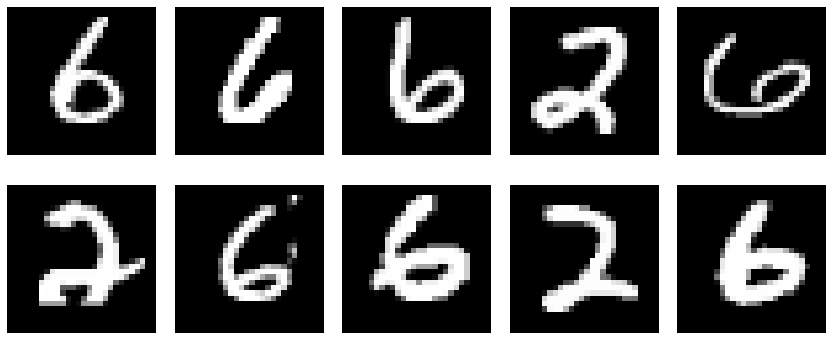

In [41]:
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = easy[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

## Random 'difficult' images

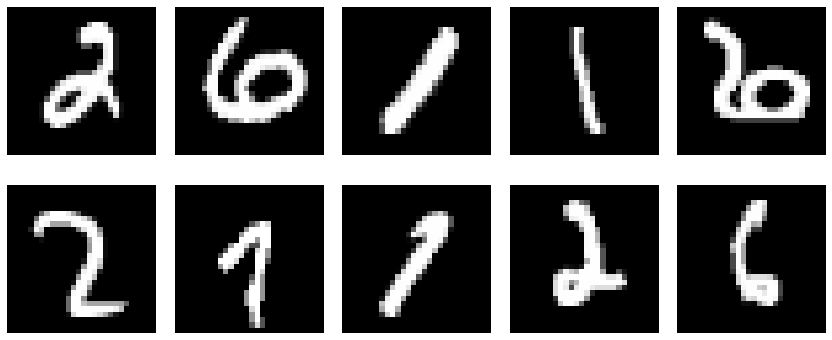

In [42]:
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = difficult[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")  

## Summary

Populate this section with all of your findings and comments fron the discussion with your peers.

# Reference
- [1] Deng, L., 2012. The mnist database of handwritten digit images for machine learning research. IEEE Signal Processing Magazine, 29(6), pp.141–142. 